<a href="https://colab.research.google.com/github/dhiru-c/Facial-Emotion-Recognition/blob/main/FER_CNN_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Introduction**

The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms.

Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms. One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge.

In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention. Digital classrooms are conducted via video telephony software program (ex- Zoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance. While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts
which can be analysed using deep learning algorithms. Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

## **Problem Statements**

We will solve the above-mentioned challenge by applying deep learning algorithms to live video data. The solution to this problem is by recognizing facial emotions.

**Face Emotion Recognition:**
This is a few shot learning live face emotion detection system. The model should be able to real-time identify the emotions of students in a live class.

# **Importing Libraries**

In [4]:
# Importing libraries and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, VGG16, VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D,MaxPooling2D, BatchNormalization, Flatten, Dropout, Dense,Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import os 
tf.random.set_seed(42)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Downloading the dataset
!gdown --id 1kdAI0wrR_bTBs-6pbKB6giz-JcNaTY-s

# Unzipping the files
!unzip '/content/dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [7]:
# Defining te path of train and test dataset
train_dir = '/content/train'
test_dir = '/content/test'

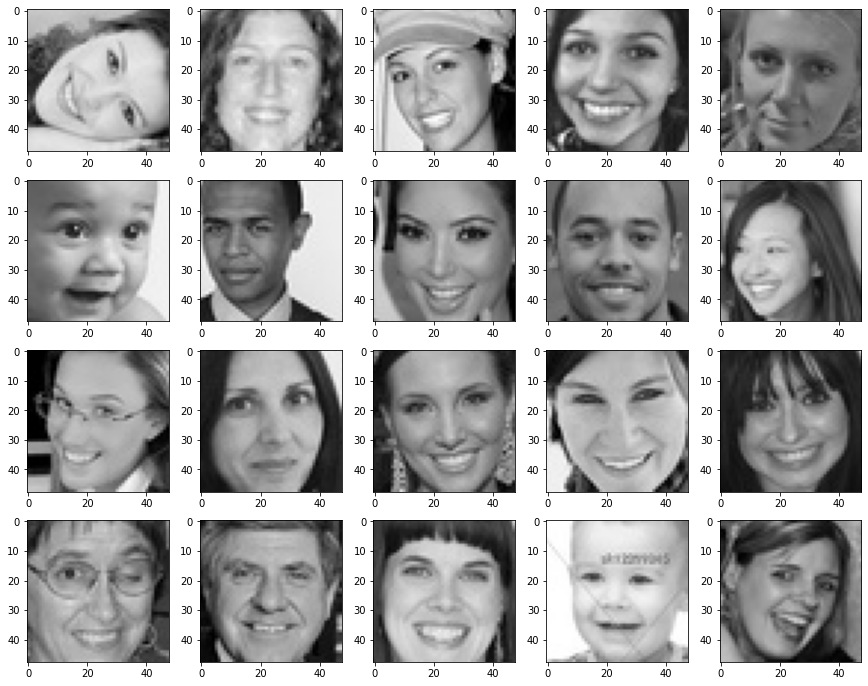

In [8]:
# Displaying sample Images
path = '/content/train/happy/'
plt.figure(figsize=(15,12))
for i in range(1, 21):
    plt.subplot(4,5,i)
    img = load_img(path + os.listdir(path)[i])
    plt.imshow(img)   
plt.show()

In [9]:
# Generating batches of tensor image data with real-time data augmentation.
batch = 64
img = (48,48)
color = "grayscale"
valid_gen = ImageDataGenerator(rescale=1./255)
train_gen = ImageDataGenerator(rotation_range=20, rescale=1./255, shear_range=0.1, zoom_range=0.2, horizontal_flip=True,
                              width_shift_range=0.1, height_shift_range=0.1)

train_data = train_gen.flow_from_directory(train_dir, target_size=img, batch_size=batch, color_mode=color, class_mode="categorical")
validation = valid_gen.flow_from_directory(test_dir, target_size=img, batch_size=batch, color_mode=color, class_mode="categorical")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


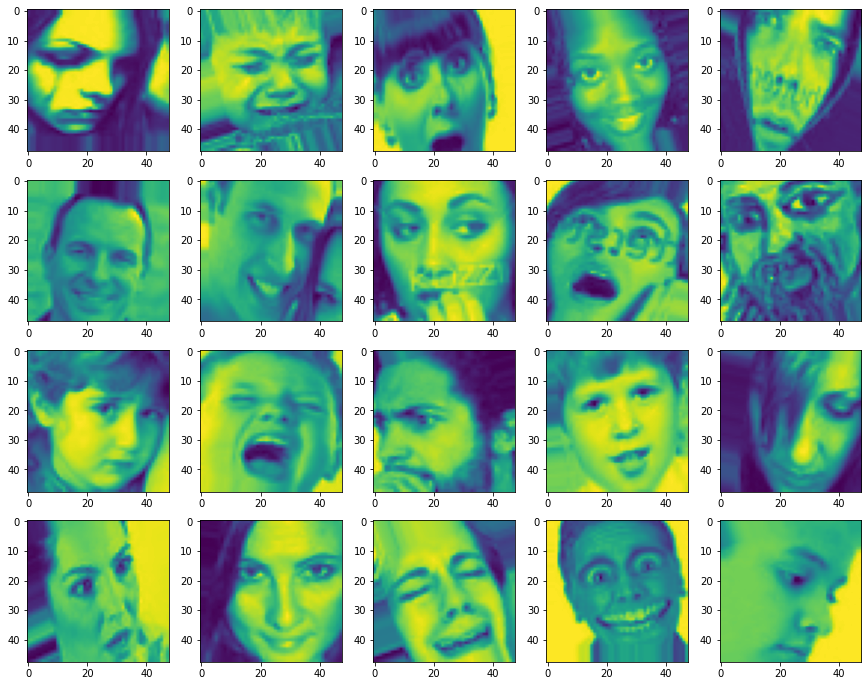

In [10]:
# Displaying sample images from the training set after augmentation
random_image = np.random.choice(64, size=20, replace=False)
random_batch = np.random.choice(112,size=20, replace=False)
fig,axes=plt.subplots(4,5,figsize=(15,12))
for id, ax in enumerate(axes.flatten()):
  pic = train_data[random_batch[id]][0][random_image[id]]
  ax.imshow(pic.reshape(48,-1))

In [11]:
# checking te shape of image and the label
image_batch, label_batch = next(iter(train_data))
print('image shape',image_batch[0].shape)
print('Label shape',label_batch[0].shape)

image shape (48, 48, 1)
Label shape (7,)


# **Defining prerequisites**

In [12]:
# Defining te default optimizer for compiling te models
opt = Adam(learning_rate=0.0001, decay=1e-6)

In [13]:
# Defining a function to generate callbacks
def callback_list(name, esp=9, lrp=3):
    ''' Defining a function to generate the list of callbacks
    Arguments:
        name -- name of the model
        esp -- early stopping patience
        lrp -- reduce learning rate patience
    Returns:
        the list of callbacks
    '''
    # Callback to save the Keras model or model weights at some frequency.
    checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/{name}.h5", monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    # Stop training when a monitored metric has stopped improving.
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=esp, verbose=1, restore_best_weights=True)
    # Reduce learning rate when a metric has stopped improving.
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=lrp, verbose=1, min_delta=0.0001)
    # Defining a list of all the callbacks
    callbacks = [earlystop, checkpoint, reduce_lr]

    return callbacks

In [14]:
def plots(history):
  ''' Defining a function to Plot the accuracy and loss
    Arguments:
        name -- name of the model
        esp -- early stopping patience
        lrp -- reduce learning rate patience
    Returns:
        the list of callbacks
    '''

  # Plot the training and validation accuracy
  acc = [0.] + history.history['accuracy']
  val_acc = [0.] + history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.figure(figsize=(20, 5))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [15]:
labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    plt.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
def FER_LeNet_model(input_shape=(48,48,1)):
  visible = Input(shape=input_shape, name='input')
  num_classes = 7

  #1stblock with 2 conv
  conv1_1 = Conv2D(6, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
  conv1_1 = BatchNormalization()(conv1_1)
  pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_1)
  drop1_1 = Dropout(0.1, name = 'drop1_1')(pool1_1)

  #the 2-nd block with 2 conv
  conv2_1 = Conv2D(16, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
  conv2_1 = BatchNormalization()(conv2_1)
  pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_1)
  drop2_1 = Dropout(0.1, name = 'drop2_1')(pool2_1)
  
  
  

  #Flatten and output
  flatten = Flatten(name = 'flatten')(drop2_1)
  FC1 = Dense(120, activation="relu", name = 'FullyConnected1')(flatten)
  FC2 = Dense(84, activation="relu", name = 'FullyConnected2')(FC1)
  ouput = Dense( num_classes, activation='softmax', name = 'output')(FC2)

  # create model 
  model = Model(inputs =visible, outputs = ouput)
    
  return model

In [17]:
model1 = FER_LeNet_model()
opt = Adam(lr=0.0001, decay=1e-6)
model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model1.summary()

# Plot model graph
plot_model(model1, show_shapes=True, to_file='lenet.png', rankdir='LR', show_layer_names=False)

#training model
history1 = model1.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('leNet'))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 6)         60        
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 6)        24        
 ormalization)                                                   
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 6)         0         
                                                                 
 drop1_1 (Dropout)           (None, 24, 24, 6)         0         
                                                                 
 conv2_1 (Conv2D)            (None, 24, 24, 16)        880       
                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
448/449 [============================>.] - ETA: 0s - loss: 1.8444 - accuracy: 0.2490
Epoch 1: val_loss improved from inf to 1.78915, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/leNet.h5
449/449 [==============================] - 35s 50ms/step - loss: 1.8441 - accuracy: 0.2491 - val_loss: 1.7892 - val_accuracy: 0.2796 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.7652 - accuracy: 0.2760
Epoch 2: val_loss improved from 1.78915 to 1.69026, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/leNet.h5
449/449 [==============================] - 22s 49ms/step - loss: 1.7652 - accuracy: 0.2760 - val_loss: 1.6903 - val_accuracy: 0.3309 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.7328 - accuracy: 0.3022
Epoch 3: val_loss improved from 1.69026 to 1.65224, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/leNet.h5
449/449 [==

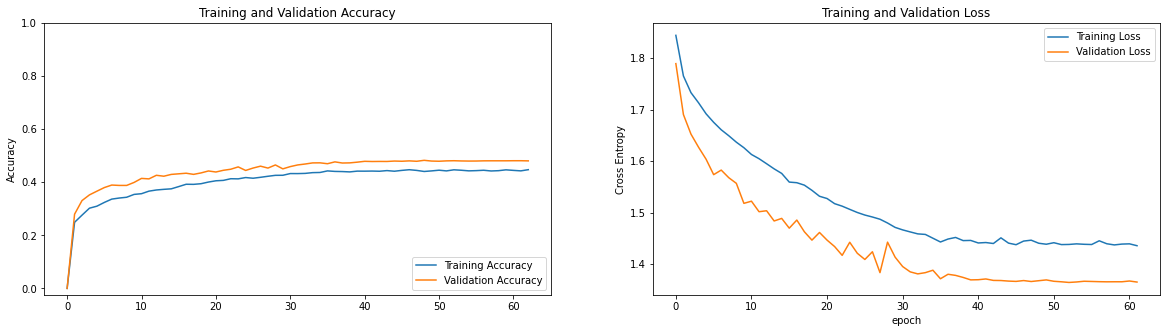

In [18]:
plots(history1)

# **AlexNet**

In [19]:
def FER_alexnet_model(input_shape=(48,48,1)):
  visible = Input(shape=input_shape, name='input')
  num_classes = 7

  #1stblock with 1 conv
  conv1_1 = Conv2D(96, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
  conv1_1 = BatchNormalization()(conv1_1)
  pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_1)

  #the 2-nd block with 1 conv
  conv2_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(pool1_1)
  conv2_1 = BatchNormalization()(conv2_1)
  pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_1)
  
  
  #the 3-rd block with 3 conv
  conv3_1 = Conv2D(384, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(pool2_1)
  conv3_1 = BatchNormalization()(conv3_1)
  conv3_2 = Conv2D(384, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
  conv3_2 = BatchNormalization()(conv3_2)
  conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
  conv3_3 = BatchNormalization()(conv3_3)
  pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_3)

  #Flatten and output
  flatten = Flatten(name = 'flatten')(pool3_1)
  FC1 = Dense(4096, activation="relu", name = 'FullyConnected1')(flatten)
  drop1_1 = Dropout(0.4, name = 'drop1_1')(FC1)
  FC2 = Dense(4096, activation="relu", name = 'FullyConnected2')(drop1_1)
  drop1_2 = Dropout(0.4, name = 'drop1_2')(FC2)
  FC3 = Dense(1000, activation="relu", name = 'FullyConnected3')(drop1_2)
  drop1_3 = Dropout(0.4, name = 'drop1_3')(FC3)
  ouput = Dense( num_classes, activation='softmax', name = 'output')(drop1_3)

  # create model 
  model = Model(inputs =visible, outputs = ouput)
    
  return model

In [20]:
model2 = FER_alexnet_model()
opt = Adam(lr=0.0001, decay=1e-6)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model2.summary()

# Plot model graph
plot_model(model2, show_shapes=True, to_file='alexnet.png', rankdir='LR', show_layer_names=False)

#training model
history2 = model2.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('AlexNet'))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 96)        960       
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 96)       384       
 hNormalization)                                                 
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 96)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 24, 24, 256)       221440    
                                                                 
 batch_normalization_3 (Batc  (None, 24, 24, 256)      1024      
 hNormalization)                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.9698 - accuracy: 0.2354
Epoch 1: val_loss improved from inf to 1.81712, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/AlexNet.h5
449/449 [==============================] - 36s 75ms/step - loss: 1.9698 - accuracy: 0.2354 - val_loss: 1.8171 - val_accuracy: 0.2427 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.7460 - accuracy: 0.2933
Epoch 2: val_loss improved from 1.81712 to 1.59412, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/AlexNet.h5
449/449 [==============================] - 36s 80ms/step - loss: 1.7460 - accuracy: 0.2933 - val_loss: 1.5941 - val_accuracy: 0.3774 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.6446 - accuracy: 0.3450
Epoch 3: val_loss improved from 1.59412 to 1.46024, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/AlexNet.h5
449/4

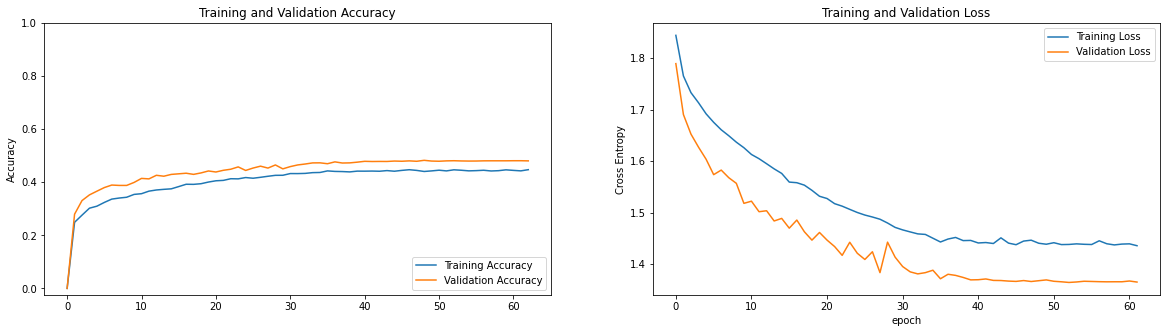

In [21]:
plots(history1)

# **VGG16**

In [22]:
# categorical classification using VGG16 
vgg16 = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for vgg16
                    Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                    # Using VGG16 and Flattening the output
                    VGG16(include_top=False), Flatten(), BatchNormalization(),
                    # Using 2 fully connected layer with 4096 units and relu activation
                    Dense(4096, activation='relu'), BatchNormalization(),
                    Dense(4096, activation='relu'), BatchNormalization(),
                    # Using a prediction layer with seven neuron
                    Dense(7, activation='softmax')])

# Compiling the model
opt = Adam(learning_rate=0.0001, decay=1e-6)
vgg16.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# checking summary
vgg16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 3)         30        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization_7 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 batch_normalization_8 (Batc  (None, 4096)             16

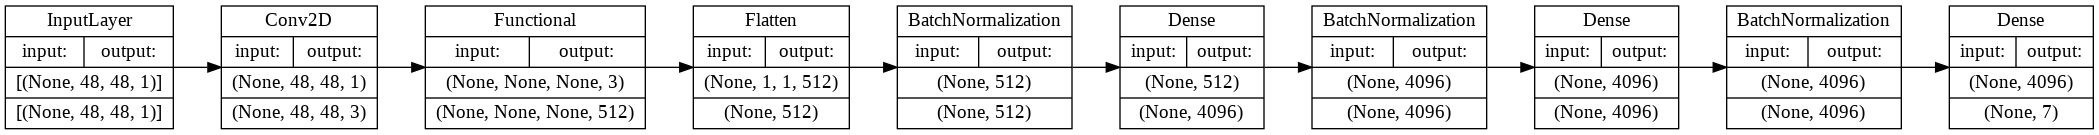

In [23]:
# Plot model graph
plot_model(vgg16, show_shapes=True, to_file='vgg16.png', rankdir='LR', show_layer_names=False)

In [24]:
# Fitting the model
history3 = vgg16.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('vgg16'))

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.8668 - accuracy: 0.3125
Epoch 1: val_loss improved from inf to 2.28401, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/vgg16.h5
449/449 [==============================] - 40s 82ms/step - loss: 1.8668 - accuracy: 0.3125 - val_loss: 2.2840 - val_accuracy: 0.2570 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.5019 - accuracy: 0.4244
Epoch 2: val_loss did not improve from 2.28401
449/449 [==============================] - 34s 75ms/step - loss: 1.5019 - accuracy: 0.4244 - val_loss: 4.2713 - val_accuracy: 0.0897 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.3802 - accuracy: 0.4798
Epoch 3: val_loss did not improve from 2.28401
449/449 [==============================] - 33s 73ms/step - loss: 1.3802 - accuracy: 0.4798 - val_loss: 2.9595 - val_accuracy: 0.2561 - lr: 1.0000e-04
Epoch 4/100
449/449 [==============

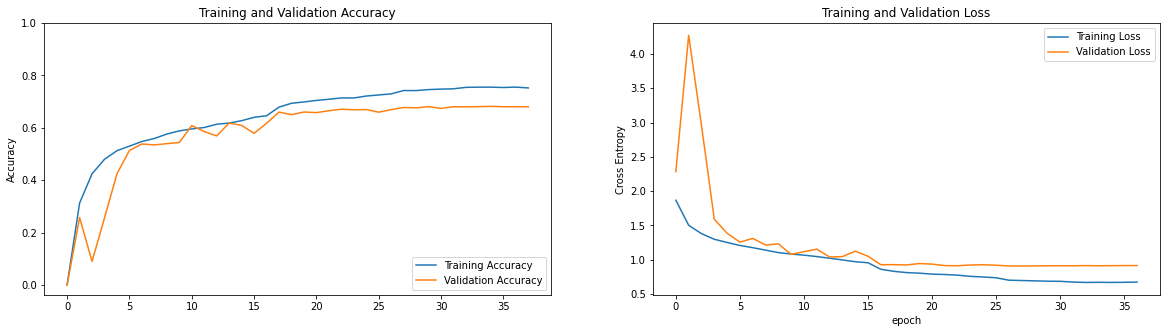

In [25]:
# Plotting te accuracy and loss
plots(history3)

# **VGG19**

In [26]:
# categorical classification using VGG19 
vgg19 = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for vgg19
                    Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                    # Using VGG19 and Flattening the output
                    VGG19(include_top=False), Flatten(), BatchNormalization(),
                    # Using 2 fully connected layer with 4096 units and relu activation
                    Dense(4096, activation='relu'), BatchNormalization(),
                    Dense(4096, activation='relu'), BatchNormalization(),
                    # Using a prediction layer with seven neuron
                    Dense(7, activation='softmax')])


# Compiling the model
opt = Adam(learning_rate=0.0001, decay=1e-6)
vgg19.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# checking summary
vgg19.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 3)         30        
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_10 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 4096)              2101248   
                                                                 
 batch_normalization_11 (Bat  (None, 4096)             

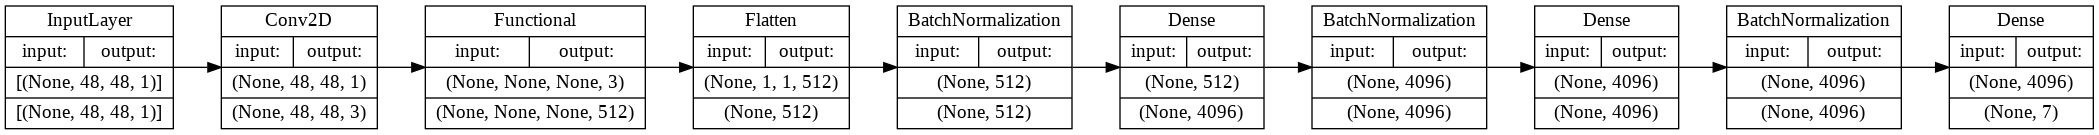

In [27]:
# Plot model graph
plot_model(vgg19, show_shapes=True, to_file='vgg19.png', rankdir='LR', show_layer_names=False)

In [28]:
# Fitting the model
history4 = vgg19.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('vgg19'))

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.9756 - accuracy: 0.2333
Epoch 1: val_loss improved from inf to 8.90001, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/vgg19.h5
449/449 [==============================] - 44s 94ms/step - loss: 1.9756 - accuracy: 0.2333 - val_loss: 8.9000 - val_accuracy: 0.1718 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.7684 - accuracy: 0.2824
Epoch 2: val_loss did not improve from 8.90001
449/449 [==============================] - 40s 89ms/step - loss: 1.7684 - accuracy: 0.2824 - val_loss: 18.2160 - val_accuracy: 0.1718 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.6196 - accuracy: 0.3687
Epoch 3: val_loss improved from 8.90001 to 3.21826, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/vgg19.h5
449/449 [==============================] - 44s 97ms/step - loss: 1.6196 - accuracy: 0.3687 - val_

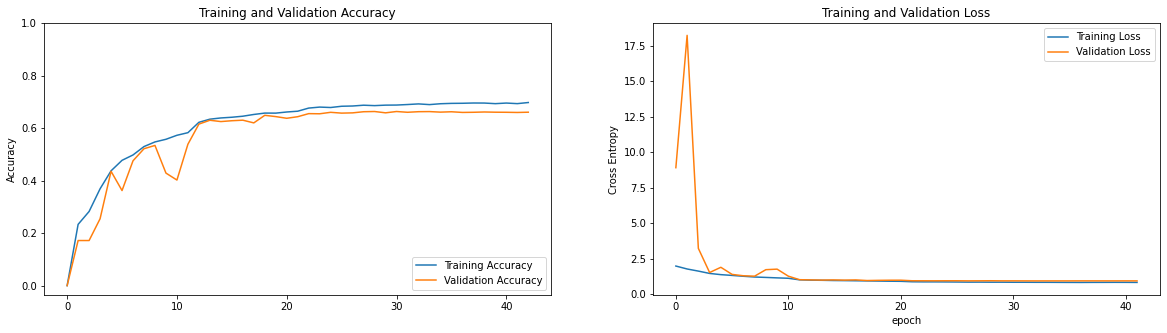

In [29]:
# Plotting te accuracy and loss
plots(history4)

# **Mobilenet**

In [30]:
# categorical classification using MobileNetV2 
mobilenet = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for mobilenet
                        Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                        # Using MobileNetV2
                        MobileNetV2(weights='imagenet', include_top=False, pooling = 'avg'),
                        # Using a fully connected layer with 128 units and relu activation
                        Dense(128, activation='relu'),
                        # Using a fully connected layer with 64 units and relu activation
                        Dense(64, activation='relu'),
                        # Using a prediction layer with seven neuron
                        Dense(7, activation='softmax')])



# Compiling the model
opt = Adam(learning_rate=0.0001, decay=1e-6)
mobilenet.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# checking summary
mobilenet.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 3)         30        
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 7)                 455       
                                                                 
Total params: 2,430,693
Trainable params: 2,396,581
Non-t

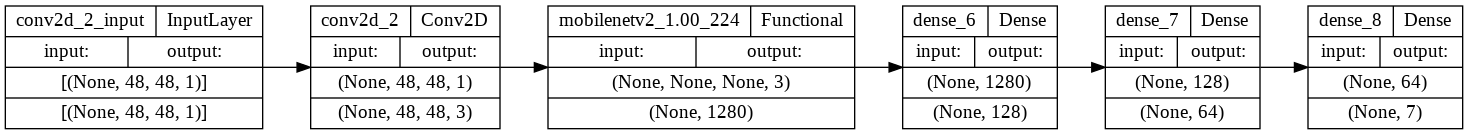

In [31]:
# Plot model graph
plot_model(mobilenet, show_shapes=True, to_file='mobilenet.png', rankdir='LR')

In [32]:
# Fitting the model
history5 = mobilenet.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('mobilenet'),shuffle = True)

Epoch 1/100
448/449 [============================>.] - ETA: 0s - loss: 1.8595 - accuracy: 0.2537
Epoch 1: val_loss improved from inf to 1.90625, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/mobilenet.h5
449/449 [==============================] - 35s 68ms/step - loss: 1.8592 - accuracy: 0.2538 - val_loss: 1.9063 - val_accuracy: 0.2446 - lr: 1.0000e-04
Epoch 2/100
448/449 [============================>.] - ETA: 0s - loss: 1.7013 - accuracy: 0.3205
Epoch 2: val_loss improved from 1.90625 to 1.87847, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/mobilenet.h5
449/449 [==============================] - 30s 66ms/step - loss: 1.7010 - accuracy: 0.3207 - val_loss: 1.8785 - val_accuracy: 0.2476 - lr: 1.0000e-04
Epoch 3/100
448/449 [============================>.] - ETA: 0s - loss: 1.6304 - accuracy: 0.3604
Epoch 3: val_loss improved from 1.87847 to 1.83067, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/mobilenet.h5

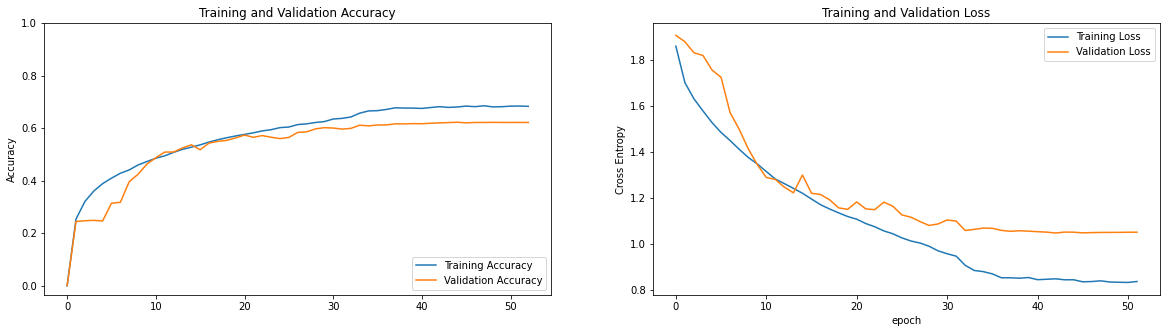

In [33]:
# Plotting te accuracy and loss
plots(history5)

# **ResNet**

In [34]:
resnet = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for resnet
                        Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                        # Using resnet152
                        tf.keras.applications.ResNet152(weights='imagenet', include_top=False, pooling='max'),
                        Flatten(), BatchNormalization(),
                        # Using a fully connected layer with 1000 units and relu activation
                        Dense(4096, activation='relu'),BatchNormalization(),Dropout(0.4),
                        Dense(1024, activation='relu'),BatchNormalization(),Dropout(0.4),
                        Dense(512, activation='relu'),BatchNormalization(),
                        # Using a prediction layer with seven neuron
                        Dense(7, activation='softmax')])


# Compiling the model
opt = Adam(learning_rate=0.0001, decay=1e-6)
resnet.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# checking summary
resnet.summary()

234708992/234698864 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 3)         30        
                                                                 
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_13 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 4096)              8392704   
                                                                 
 batch_normalization_14 (Bat  (None, 4096)           

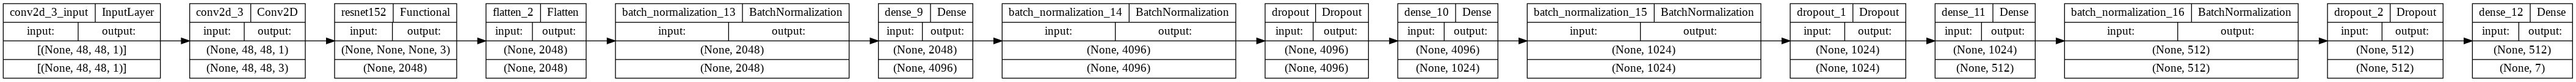

In [35]:
# Plot model graph
plot_model(resnet, show_shapes=True, to_file='resnet.png', rankdir='LR')

In [36]:
# Fitting the model
history6 = resnet.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('resnet'))

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 2.4175 - accuracy: 0.2391
Epoch 1: val_loss improved from inf to 2.16291, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/resnet.h5
449/449 [==============================] - 111s 204ms/step - loss: 2.4175 - accuracy: 0.2391 - val_loss: 2.1629 - val_accuracy: 0.1718 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.9287 - accuracy: 0.3368
Epoch 2: val_loss improved from 2.16291 to 1.88975, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/resnet.h5
449/449 [==============================] - 93s 206ms/step - loss: 1.9287 - accuracy: 0.3368 - val_loss: 1.8897 - val_accuracy: 0.3033 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.7395 - accuracy: 0.3799
Epoch 3: val_loss improved from 1.88975 to 1.45469, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/resnet.h5
449/4

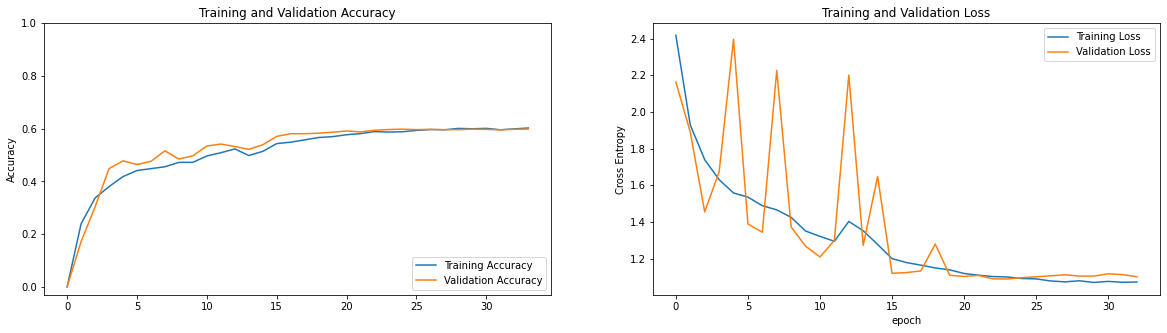

In [37]:
# Plotting te accuracy and loss
plots(history6)

# **Basic Inception**

In [38]:
# Defining a function for basic inception model
def basic_inception(input_shape=(48,48,1), F1=32, F3_in=32, F3_out=64, F5_in=8, F5_out=16, Mp_out=16):
    ''' Defining a basic inception model for categorical classification out of the two inception blocks
    Arguments:
        input_shape -- Image width,height and channels
        F1 -- Number of 1x1 filters
        F3_in -- Number of 1x1 filters to place before the 3x3 filter
        F3_out -- Number of 3x3 filters
        F5_in -- Number of 1x1 filters to place before the 5x5 filter
        F5_out -- Number of 5x5 filters
        Mp_out -- Number of 1x1 filters to place after maxpooling
    Returns:
        basic inception model with 3 inception blocks, 2 FC layers and one prediction layer wit 7 neurons.
    '''
    # Define input
    inputs = Input(shape=input_shape)

    # Creating a basic inception block
    def inception_block(input_layer, f1=F1, f3_in=F3_in, f3_out=F3_out, f5_in=F5_in, f5_out=F5_out, mp_out=Mp_out):
        # 1x1 Convolution
        conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(input_layer)
        # 3x3 Convolution
        conv3 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(input_layer)
        conv3 = Conv2D(f3_out, (3,3), padding='same', activation='relu')(conv3)
        # 5x5 Convolution
        conv5 = Conv2D(f5_in, (1,1), padding='same', activation='relu')(input_layer)
        conv5 = Conv2D(f5_out, (5,5), padding='same', activation='relu')(conv5)
        # 3x3 Max Pooling
        pool = MaxPool2D((3,3), strides=(1,1), padding='same')(input_layer)
        pool = Conv2D(mp_out, (1,1), padding='same', activation='relu')(pool)
        # Concatenate
        layer_out = Concatenate(axis=-1)([conv1, conv3, conv5, pool])
        return layer_out

    # First inception block
    iblock1 = inception_block(inputs)
    iblock1 = BatchNormalization()(iblock1)
    # Second inception block
    iblock2 = inception_block(iblock1)
    iblock2 = BatchNormalization()(iblock2)
    # Third inception block
    iblock3 = inception_block(iblock2)
    
    # Flattening for output
    flat = Flatten()(iblock3)
    flat = BatchNormalization()(flat)
    
    # Adding 2 FC layers and the prediction layer
    dense1 = Dense(256, activation='relu')(flat)
    dense1 = BatchNormalization()(dense1)
    dense2 = Dense(128, activation='relu')(dense1)
    dense2 = BatchNormalization()(dense2)
    outputs = Dense(7, activation='softmax')(dense2)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [39]:
# Defining the model
inception = basic_inception()

# Compiling the model
opt = Adam(learning_rate=0.0001, decay=1e-6)
inception.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# checking summary
inception.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 48, 48, 32)   64          ['input_5[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 48, 48, 8)    16          ['input_5[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 48, 1)    0           ['input_5[0][0]']                
                                                                                            

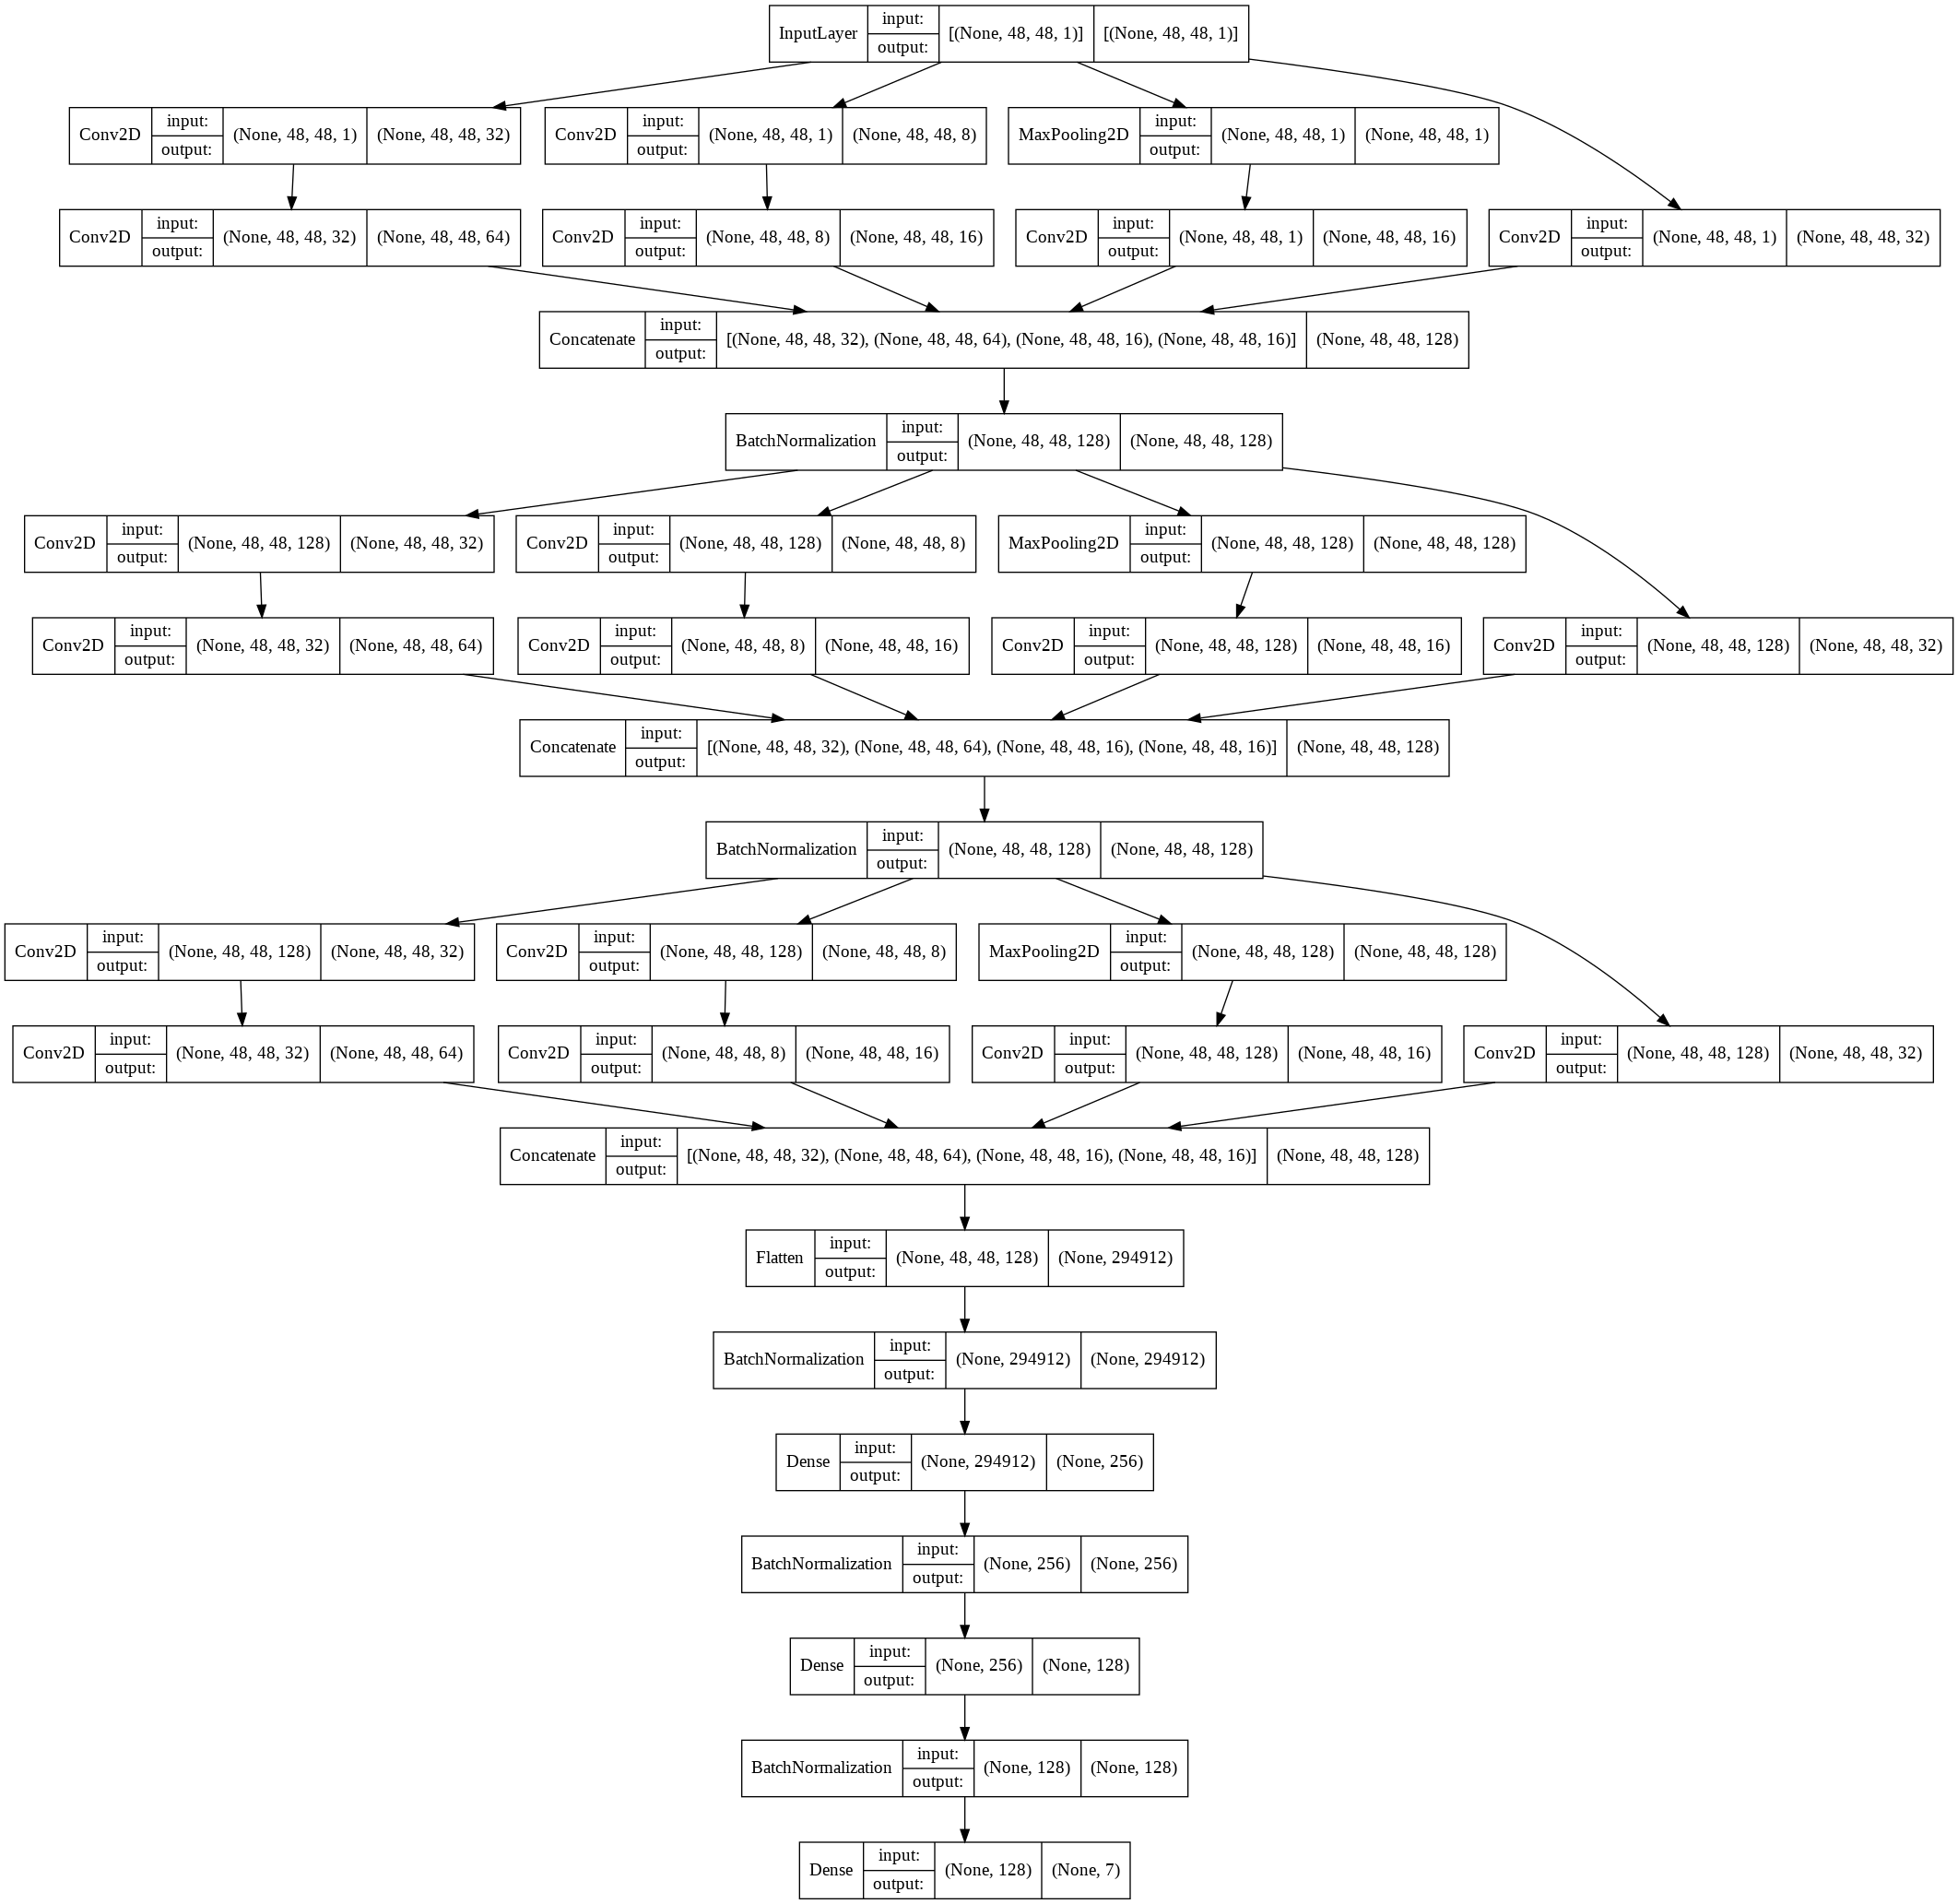

In [40]:
# Plot model graph
plot_model(inception, show_shapes=True, to_file='inception.png', show_layer_names=False)

In [41]:
# Fitting the model
history7 = inception.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('inception'))

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.8453 - accuracy: 0.3019
Epoch 1: val_loss improved from inf to 2.00818, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/inception.h5
449/449 [==============================] - 59s 126ms/step - loss: 1.8453 - accuracy: 0.3019 - val_loss: 2.0082 - val_accuracy: 0.2657 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.6563 - accuracy: 0.3720
Epoch 2: val_loss improved from 2.00818 to 1.97812, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/inception.h5
449/449 [==============================] - 60s 135ms/step - loss: 1.6563 - accuracy: 0.3720 - val_loss: 1.9781 - val_accuracy: 0.2994 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.5649 - accuracy: 0.4054
Epoch 3: val_loss improved from 1.97812 to 1.52692, saving model to /content/drive/MyDrive/capstone projects/DL/FER_MODEL_H5/inception.

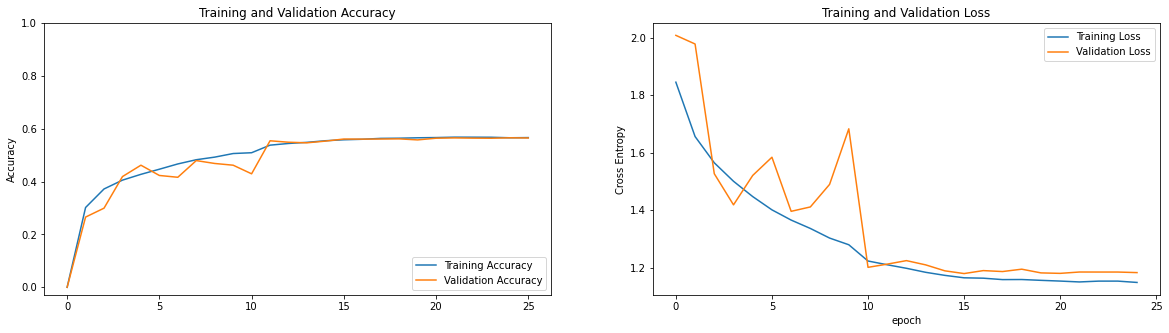

In [42]:
plots(history7)